## Reading the data

In [26]:
import sys
sys.path.append('../scripts')  # Appending the path to access the scripts folder
from functions2 import * 

In [27]:

query = "SELECT * FROM xdr_data;"  # Adjust the table name as needed
df = fetch_data_from_db('telecom', 'postgres', 'root', 'localhost', query)
    
    
display(df.head())


c:\Users\Toshiba\Documents\Kifiya\week 2\notebooks\../scripts\functions2.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


## Data cleaning


In [28]:

df = clean_and_transform_data(df)
display(df.describe())


C:\Users\Toshiba\AppData\Local\Temp\ipykernel_14420\616870405.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['session_duration'].fillna(df['session_duration'].mean(), inplace=True)
C:\Users\Toshiba\AppData\Local\Temp\ipykernel_14420\616870405.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

,Bearer Id,Start ms,End ms,session_duration,IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),total_ul_bytes,total_dl_bytes,total_traffic
count,1.485060e+05,148935.000000,148935.000000,1.489350e+05,1.489350e+05,1.489350e+05,1.489350e+05,121291.000000,121310.000000,148935.000000,...,1.489350e+05,1.489350e+05,1.489350e+05,1.489350e+05,1.489350e+05,1.489350e+05,1.489350e+05,1.489350e+05,1.489350e+05,1.489350e+05
mean,1.014676e+19,499.246732,498.675442,1.048702e+05,2.082016e+14,4.188282e+10,4.849493e+13,108.224741,17.637235,13286.171390,...,1.100867e+07,1.162756e+07,1.100017e+07,4.220256e+08,8.289085e+06,4.211473e+08,8.263189e+06,4.111764e+07,4.546251e+08,4.957428e+08
std,2.893262e+18,288.555630,288.089136,8.106343e+04,1.522166e+10,2.447443e+12,2.242829e+13,594.299952,84.793054,23978.591234,...,6.345428e+06,6.724686e+06,6.358918e+06,2.439763e+08,4.782090e+06,2.431970e+08,4.768708e+06,1.127933e+07,2.441528e+08,2.443876e+08
min,6.917538e+18,0.000000,0.000000,7.142000e+03,2.040471e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,0.000000,...,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06,2.895611e+07
25%,7.349883e+18,250.000000,251.000000,5.788350e+04,2.082014e+14,3.365130e+10,3.546071e+13,32.000000,2.000000,43.000000,...,5.516710e+06,5.779947e+06,5.474451e+06,2.104587e+08,4.130162e+06,2.102119e+08,4.145072e+06,3.321774e+07,2.430996e+08,2.844641e+08
50%,7.349883e+18,499.000000,500.000000,8.639900e+04,2.082015e+14,3.366371e+10,3.572221e+13,45.000000,5.000000,63.000000,...,1.101329e+07,1.164269e+07,1.099563e+07,4.234208e+08,8.291222e+06,4.218716e+08,8.266089e+06,4.114101e+07,4.558708e+08,4.968460e+08
75%,1.304243e+19,749.000000,750.000000,1.327000e+05,2.082018e+14,3.368349e+10,8.611970e+13,69.000000,15.000000,19681.000000,...,1.651442e+07,1.747072e+07,1.650429e+07,6.331620e+08,1.243184e+07,6.316602e+08,1.238204e+07,4.903248e+07,6.656577e+08,7.064483e+08
max,1.318654e+19,999.000000,999.000000,1.859336e+06,2.082522e+14,8.823971e+14,9.900120e+13,96923.000000,7120.000000,378160.000000,...,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08,9.559848e+08


## User Engagement Analysis

session_duration                                           \
                     min         max           mean           sum   
cluster                                                             
0                83071.0  18553754.0  626185.138982  2.815955e+09   
1                 7258.0    869844.0  164767.463317  6.441090e+09   
2                 7142.0    869830.0  100554.687436  6.361793e+09   

        total_traffic                                            
                  min           max          mean           sum  
cluster                                                          
0         118487293.0  8.846226e+09  2.143717e+09  9.640296e+12  
1         139153646.0  2.299610e+09  9.860550e+08  3.854686e+13  
2          33249009.0  7.871592e+08  4.053660e+08  2.564629e+13

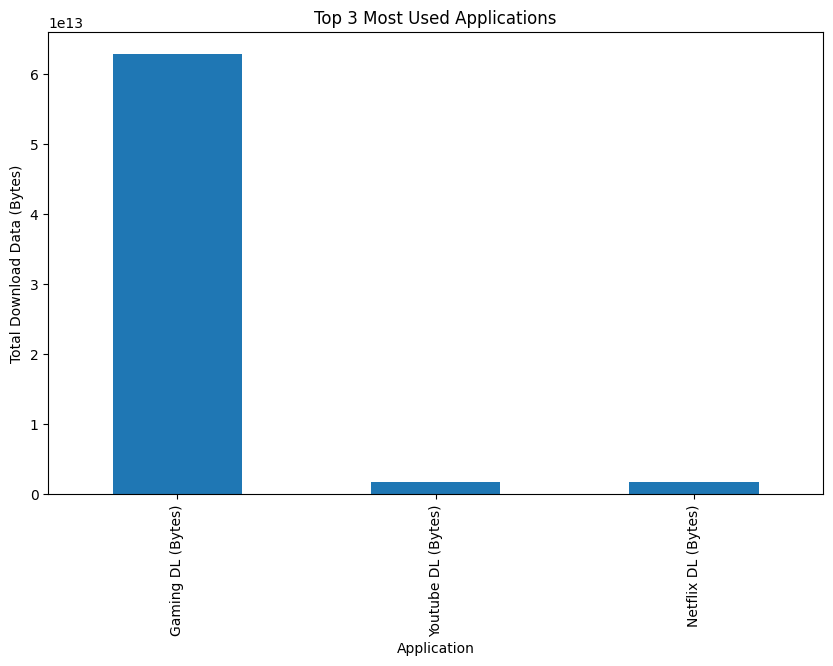

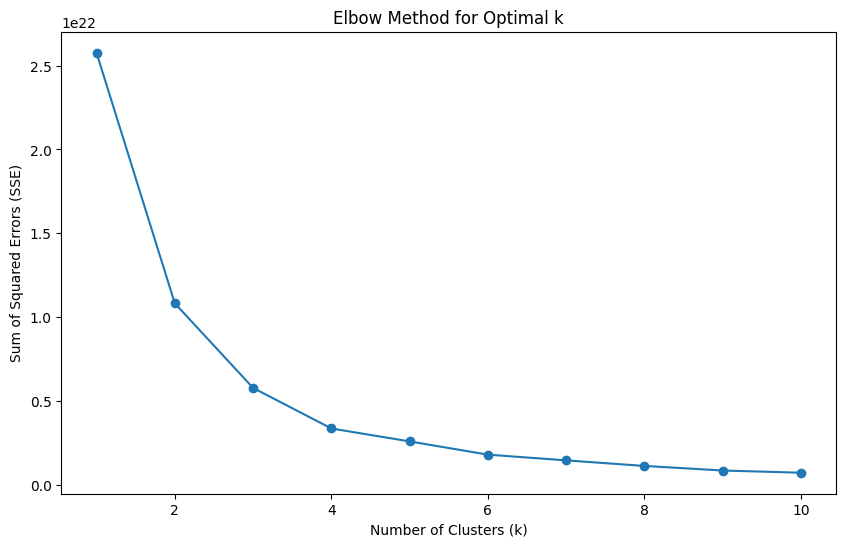

In [29]:
user_engagement = aggregate_user_engagement(df)
user_engagement = perform_clustering(user_engagement, n_clusters=3)
    
    # Print cluster summary
cluster_summary = summarize_clusters(user_engagement)
display(cluster_summary)

    # Plot the top applications
plot_top_applications(df)

    # Perform the elbow method to find optimal k
elbow_method(user_engagement[['session_duration', 'total_traffic']].values, max_k=10)
